In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [3]:
tf.config.run_functions_eagerly(True)

In [4]:
df = tfds.load('ColorectalHistology', split='train[:80%]')
df

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incomplete0PU6FD/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<PrefetchDataset element_spec={'filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(150, 150, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
df_train = tfds.load('ColorectalHistology', split='train[:80%]', as_supervised=True)
df_test = tfds.load('ColorectalHistology', split='train[-20%:]',as_supervised=True)

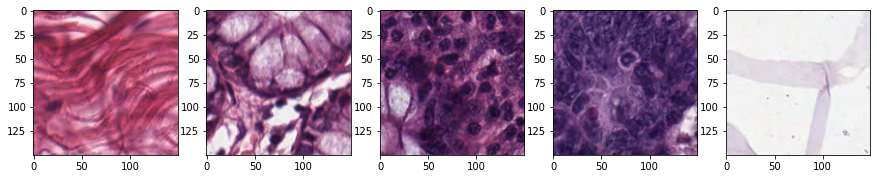

In [64]:
#Is dataset well uploaded?
fig, axs = plt.subplots(1, 5,figsize=(15,15))
for i in range(5) :  
  for image, label in df_train.take(i+1) :
      axs[i].imshow(image)

In [6]:
#Preprocess
def resizing_images(image,label) :  
  return(tf.image.resize(image,[50,50])/255 , label)


df_train = df_train.map(resizing_images)
df_test = df_test.map(resizing_images)

df_train=df_train.batch(16)
df_test=df_test.batch(16)

In [59]:
#First model
from tensorflow.python.ops.gen_math_ops import mod_eager_fallback

model = keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(50, 50, 3)))
model.add(keras.layers.Dense(activation='relu', units=128))
model.add(keras.layers.Dense(activation='softmax', units=8))
     

In [60]:
#Model configuration for training
model.compile(optimizer='adam', #stochastic gradient descent
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #SparseCategoricalCrossentropy because we are in a categorical classifier problem
              metrics=['accuracy'])

In [61]:
#Launching epochs
model_epochs = model.fit(df_train, epochs=20, validation_data = df_test)

Epoch 1/20
250/250 [==============================] - 7s 29ms/step - loss: 2.1917 - accuracy: 0.2988 - val_loss: 1.4593 - val_accuracy: 0.4010
Epoch 2/20
250/250 [==============================] - 6s 24ms/step - loss: 1.4516 - accuracy: 0.3923 - val_loss: 1.2123 - val_accuracy: 0.4090
Epoch 3/20
250/250 [==============================] - 6s 24ms/step - loss: 1.2195 - accuracy: 0.4540 - val_loss: 1.1289 - val_accuracy: 0.4320
Epoch 4/20
250/250 [==============================] - 6s 24ms/step - loss: 1.1371 - accuracy: 0.4960 - val_loss: 1.1284 - val_accuracy: 0.4530
Epoch 5/20
250/250 [==============================] - 6s 24ms/step - loss: 1.0818 - accuracy: 0.5205 - val_loss: 1.0967 - val_accuracy: 0.4730
Epoch 6/20
250/250 [==============================] - 6s 24ms/step - loss: 1.0416 - accuracy: 0.5393 - val_loss: 1.1026 - val_accuracy: 0.4730
Epoch 7/20
250/250 [==============================] - 6s 24ms/step - loss: 0.9938 - accuracy: 0.5590 - val_loss: 1.1136 - val_accuracy: 0.4870

In [62]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 7500)              0         
                                                                 
 dense_28 (Dense)            (None, 128)               960128    
                                                                 
 dense_29 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 961,160
Trainable params: 961,160
Non-trainable params: 0
_________________________________________________________________


In [63]:
#Plotting accuracy and loss functions
def plot_model_accuracy_loss(epochs):
  fig, axs = plt.subplots(1, 2,figsize=(20,10))
  axs[0].plot(epochs.history['accuracy'])
  axs[0].plot(epochs.history['val_accuracy'])
  axs[0].legend(['accuracy', 'val_accuracy'])
  axs[1].plot(epochs.history['loss'])
  axs[1].plot(epochs.history['val_loss'])
  axs[1].legend(['loss', 'val_loss'])
  plt.show()

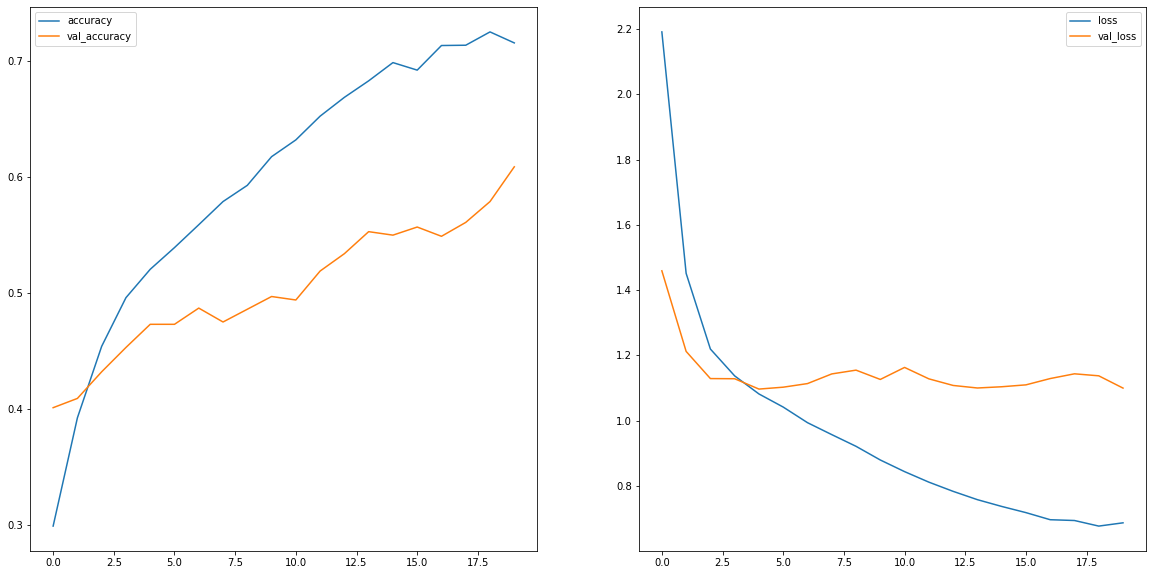

In [64]:
plot_model_accuracy_loss(model_epochs)

In [65]:
#Add Convolution2D
model_conv2d = keras.Sequential()

model_conv2d.add(keras.layers.Convolution2D(32, (3 ,3), input_shape=(50, 50, 3), activation='relu'))
model_conv2d.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d.add(keras.layers.Convolution2D(16, (3, 3), activation='relu'))
model_conv2d.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d.add(keras.layers.Convolution2D(8, (3, 3), activation='relu'))
model_conv2d.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d.add(keras.layers.Convolution2D(4, (3, 3), activation='relu'))
model_conv2d.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d.add(keras.layers.Flatten())
model_conv2d.add(keras.layers.Dense(activation='relu', units=128))
model_conv2d.add(keras.layers.Dense(activation='softmax', units=8))

In [66]:
#configuring like the previous model
model_conv2d.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [67]:
conv2d_epochs = model_conv2d.fit(df_train, epochs=10, validation_data = df_test)

Epoch 1/10
250/250 [==============================] - 27s 107ms/step - loss: 1.6156 - accuracy: 0.3100 - val_loss: 1.2782 - val_accuracy: 0.4040
Epoch 2/10
250/250 [==============================] - 26s 104ms/step - loss: 1.1491 - accuracy: 0.4930 - val_loss: 1.0556 - val_accuracy: 0.5180
Epoch 3/10
250/250 [==============================] - 25s 102ms/step - loss: 1.0412 - accuracy: 0.5430 - val_loss: 0.9895 - val_accuracy: 0.5500
Epoch 4/10
250/250 [==============================] - 26s 104ms/step - loss: 0.9960 - accuracy: 0.5648 - val_loss: 0.9584 - val_accuracy: 0.6140
Epoch 5/10
250/250 [==============================] - 25s 102ms/step - loss: 0.9546 - accuracy: 0.5865 - val_loss: 0.9624 - val_accuracy: 0.5920
Epoch 6/10
250/250 [==============================] - 25s 101ms/step - loss: 0.9277 - accuracy: 0.5995 - val_loss: 0.8933 - val_accuracy: 0.6250
Epoch 7/10
250/250 [==============================] - 26s 105ms/step - loss: 0.8971 - accuracy: 0.6220 - val_loss: 0.9203 - val_ac

In [70]:
model_conv2d.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 22, 22, 16)        4624      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 11, 11, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 9, 9, 8)           1160      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 4, 4, 8)        

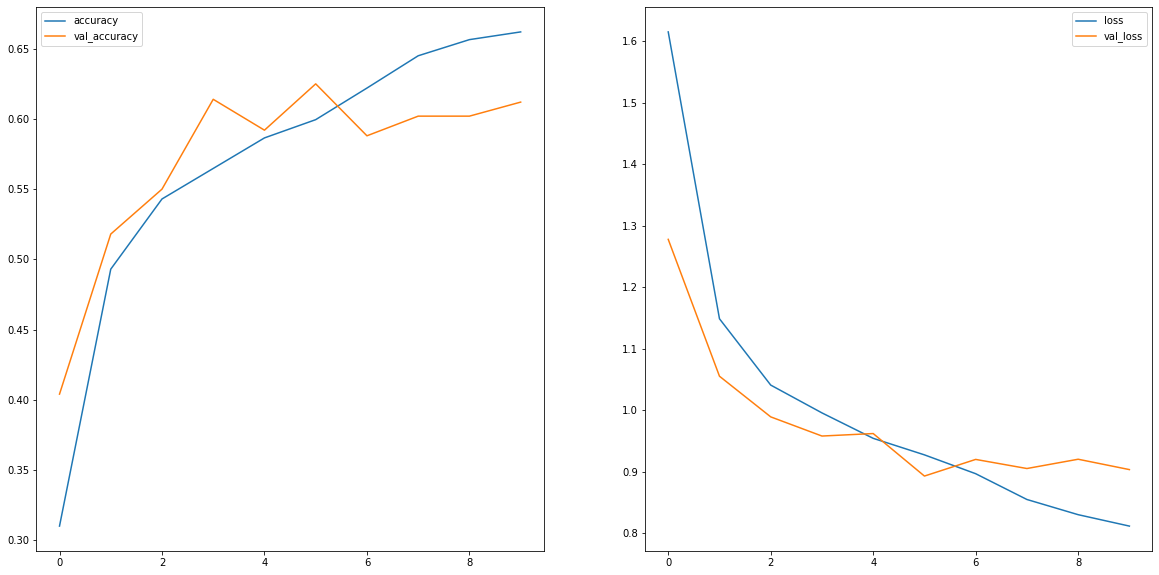

In [71]:
plot_model_accuracy_loss(conv2d_epochs)

In [72]:
#We obtain better performances, let's improve our model by changing its layers hyperparameters.
model_conv2d_opti = keras.Sequential()

model_conv2d_opti.add(keras.layers.Convolution2D(64, (3 ,3), input_shape=(50, 50, 3), activation='relu'))
model_conv2d_opti.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d_opti.add(keras.layers.Convolution2D(32, (3, 3), activation='relu'))
model_conv2d_opti.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d_opti.add(keras.layers.Convolution2D(16, (3, 3), activation='relu'))
model_conv2d_opti.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d_opti.add(keras.layers.Convolution2D(8, (3, 3), activation='relu'))
model_conv2d_opti.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_conv2d_opti.add(keras.layers.Flatten())
model_conv2d_opti.add(keras.layers.Dense(activation='relu', units=128))
model_conv2d_opti.add(keras.layers.Dense(activation='softmax', units=8))

In [73]:
model_conv2d_opti.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
conv2d_opti_epochs = model_conv2d_opti.fit(df_train, epochs=10, validation_data = df_test)

Epoch 1/10
  1/250 [..............................] - ETA: 41s - loss: 2.0793 - accuracy: 0.0625

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 37s 148ms/step - loss: 1.4063 - accuracy: 0.4015 - val_loss: 1.1216 - val_accuracy: 0.4570
Epoch 2/10
250/250 [==============================] - 37s 148ms/step - loss: 1.0781 - accuracy: 0.5265 - val_loss: 1.0121 - val_accuracy: 0.5170
Epoch 3/10
250/250 [==============================] - 37s 147ms/step - loss: 0.9806 - accuracy: 0.5817 - val_loss: 0.9267 - val_accuracy: 0.5840
Epoch 4/10
250/250 [==============================] - 37s 148ms/step - loss: 0.9100 - accuracy: 0.6083 - val_loss: 0.8322 - val_accuracy: 0.6270
Epoch 5/10
250/250 [==============================] - 37s 146ms/step - loss: 0.8455 - accuracy: 0.6440 - val_loss: 0.7779 - val_accuracy: 0.6610
Epoch 6/10
250/250 [==============================] - 36s 146ms/step - loss: 0.7822 - accuracy: 0.6860 - val_loss: 0.7548 - val_accuracy: 0.6850
Epoch 7/10
250/250 [==============================] - 37s 146ms/step - loss: 0.7559 - accuracy: 0.7020 - val_loss: 0.7865 - val_accuracy: 0.6

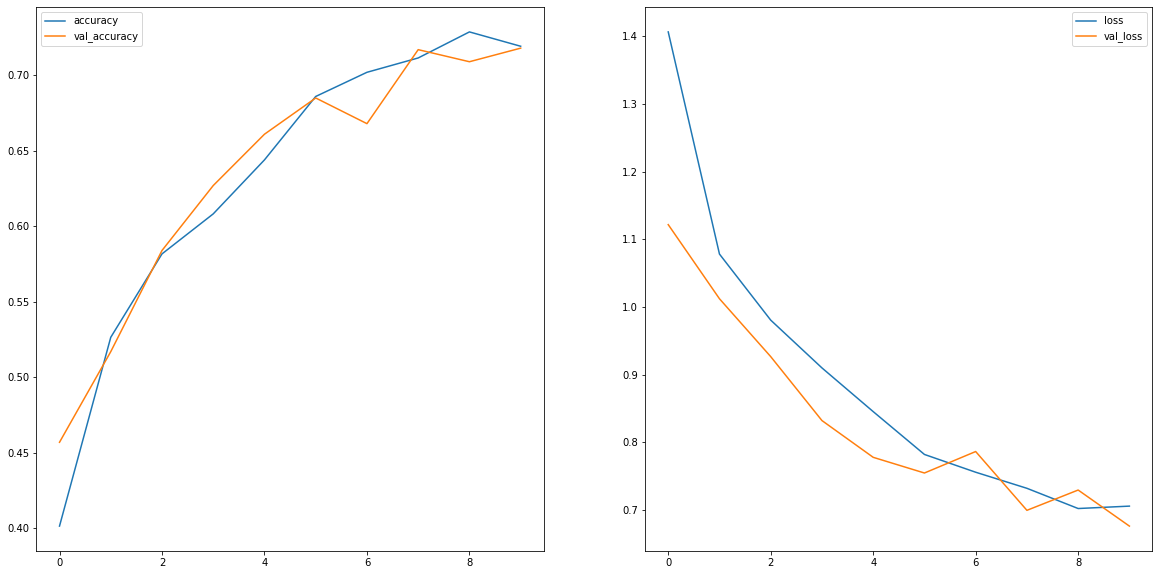

In [75]:
plot_model_accuracy_loss(conv2d_opti_epochs)

In [76]:
#Batch Normalization 
model_batch_norm = keras.Sequential()

model_batch_norm.add(keras.layers.Convolution2D(64, (3 ,3), input_shape=(50, 50, 3), activation='relu', padding='same'))
model_batch_norm.add(keras.layers.BatchNormalization())
model_batch_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_batch_norm.add(keras.layers.Convolution2D(32, (3, 3), activation='relu', padding='same'))
model_batch_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_batch_norm.add(keras.layers.Convolution2D(16, (3, 3), activation='relu', padding='same'))
model_batch_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_batch_norm.add(keras.layers.Convolution2D(8, (3, 3), activation='relu', padding='same'))
model_batch_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_batch_norm.add(keras.layers.Flatten())
model_batch_norm.add(keras.layers.Dense(activation='relu', units=128))
model_batch_norm.add(keras.layers.Dropout(0.4))
model_batch_norm.add(keras.layers.Dense(activation='softmax', units=8))

In [77]:
model_batch_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
batch_norm_epochs = model_batch_norm.fit(df_train, epochs=10, validation_data = df_test)

Epoch 1/10
250/250 [==============================] - 49s 195ms/step - loss: 1.2531 - accuracy: 0.4725 - val_loss: 1.4291 - val_accuracy: 0.4320
Epoch 2/10
250/250 [==============================] - 50s 200ms/step - loss: 0.8829 - accuracy: 0.6432 - val_loss: 0.9273 - val_accuracy: 0.6760
Epoch 3/10
250/250 [==============================] - 52s 207ms/step - loss: 0.7465 - accuracy: 0.7042 - val_loss: 0.9853 - val_accuracy: 0.5330
Epoch 4/10
250/250 [==============================] - 51s 206ms/step - loss: 0.6930 - accuracy: 0.7383 - val_loss: 0.6580 - val_accuracy: 0.7350
Epoch 5/10
250/250 [==============================] - 49s 196ms/step - loss: 0.6235 - accuracy: 0.7615 - val_loss: 0.9125 - val_accuracy: 0.6490
Epoch 6/10
250/250 [==============================] - 49s 198ms/step - loss: 0.5838 - accuracy: 0.7793 - val_loss: 0.8292 - val_accuracy: 0.6790
Epoch 7/10
250/250 [==============================] - 52s 209ms/step - loss: 0.5436 - accuracy: 0.7920 - val_loss: 0.6666 - val_ac

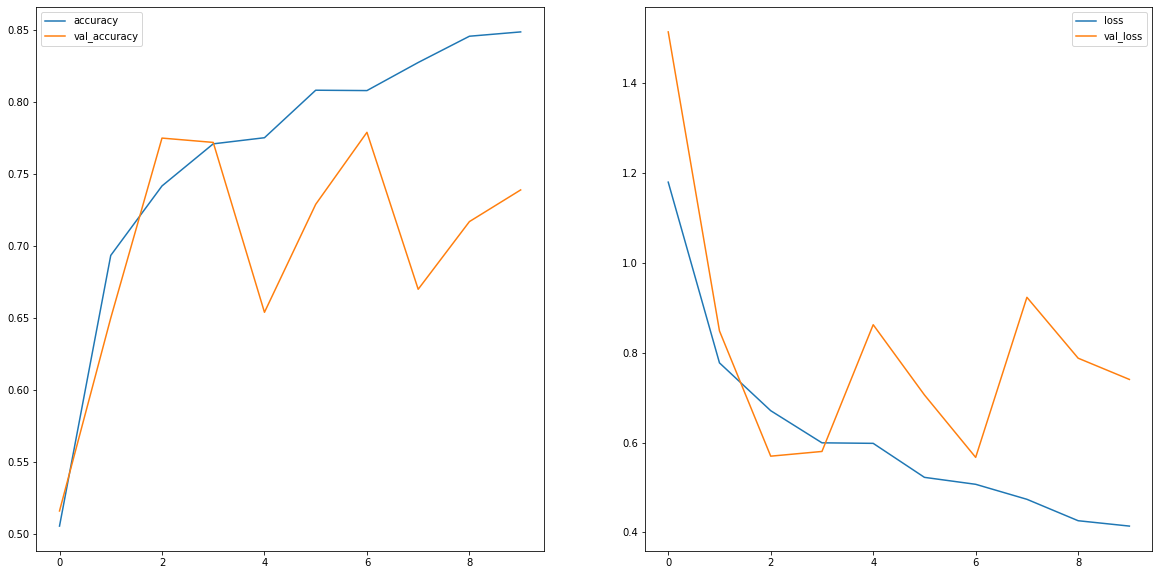

In [34]:
plot_model_accuracy_loss(batch_norm_epochs)

In [79]:
# Layer Normalization
model_layer_norm = keras.Sequential()

model_layer_norm.add(keras.layers.Convolution2D(64, (3 ,3), input_shape=(50, 50, 3), activation='relu', padding='same'))
model_layer_norm.add(keras.layers.LayerNormalization())
model_layer_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_layer_norm.add(keras.layers.Convolution2D(32, (3, 3), activation='relu', padding='same'))
model_layer_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_layer_norm.add(keras.layers.Convolution2D(16, (3, 3), activation='relu', padding='same'))
model_layer_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_layer_norm.add(keras.layers.Convolution2D(8, (3, 3), activation='relu', padding='same'))
model_layer_norm.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

model_layer_norm.add(keras.layers.Flatten())
model_layer_norm.add(keras.layers.Dense(activation='relu', units=128))
model_layer_norm.add(keras.layers.Dropout(0.4))
model_layer_norm.add(keras.layers.Dense(activation='softmax', units=8))

In [80]:
model_layer_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [81]:
layer_norm_epochs = model_layer_norm.fit(df_train, epochs=10, validation_data = df_test)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 77s 309ms/step - loss: 1.3520 - accuracy: 0.4232 - val_loss: 0.8728 - val_accuracy: 0.6240
Epoch 2/10
250/250 [==============================] - 73s 290ms/step - loss: 0.9435 - accuracy: 0.6122 - val_loss: 0.7785 - val_accuracy: 0.6860
Epoch 3/10
250/250 [==============================] - 77s 308ms/step - loss: 0.8146 - accuracy: 0.6727 - val_loss: 0.6223 - val_accuracy: 0.7490
Epoch 4/10
250/250 [==============================] - 77s 309ms/step - loss: 0.7374 - accuracy: 0.7222 - val_loss: 0.6201 - val_accuracy: 0.7790
Epoch 5/10
250/250 [==============================] - 77s 310ms/step - loss: 0.7179 - accuracy: 0.7340 - val_loss: 0.6442 - val_accuracy: 0.7650
Epoch 6/10
250/250 [==============================] - 77s 309ms/step - loss: 0.6430 - accuracy: 0.7567 - val_loss: 0.6007 - val_accuracy: 0.7690
Epoch 7/10
250/250 [==============================] - 72s 288ms/step - loss: 0.5983 - accuracy: 0.7780 - val_loss: 0.5840 - val_accuracy: 0.7

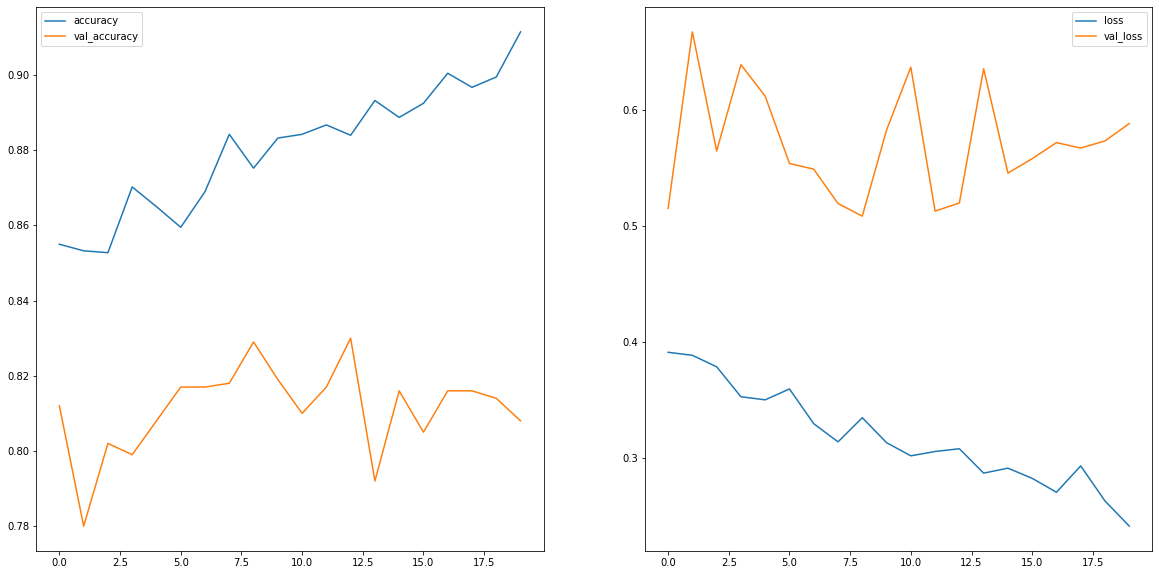

In [55]:
plot_model_accuracy_loss(layer_norm_epochs)